## Bring in libraries and dataframes and set indexes

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
#from statsmodels.formula.api import ols
#from statsmodels.stats.anova import anova_lm
#import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [4]:
ObsData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
#ObsData.columns = ObsData.columns.droplevel([3,4,5,6,7,8,10])
#ObsData = ObsData.reorder_levels(['Depth','Irrigation','Nitrogen','Block'],axis=1)
ObsData.sort_index(axis=0,inplace=True)
ObsData.sort_index(axis=1,inplace=True)
#Set up factorLevel descriptors
Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
F1 = ObsData.columns.get_level_values(1).drop_duplicates().values
F2 = ObsData.columns.get_level_values(2).drop_duplicates().values
Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values
ObsData.loc['2021-12-13 05:00:00':'2021-12-13 17:00:00',:] =np.nan

## Export top layer data for evaporation analysis

In [5]:
ObsData.loc[:,['D1B','D1I']].to_pickle('.\DataFrames\TopVWC.pkl')

In [6]:
GPs = GH.SetGraphicsPatterns(ObsData.D1B.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = ObsData.index.min()
End = ObsData.index.max()

Irrigation
['2D', '7D', '14D', '21D', 'MD', 'LD']
Species
['Peas']
Treatments
MultiIndex([( '2D', 'Peas'),
            ( '7D', 'Peas'),
            ('14D', 'Peas'),
            ('21D', 'Peas'),
            ( 'MD', 'Peas'),
            ( 'LD', 'Peas')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
         Lin     Col   Alp Mar     MFC
2D  Peas   -  orange  0.15   o  orange
7D  Peas   -   green  0.15   o   white
14D Peas   -  purple  0.15   o   white
21D Peas  --  orange  0.45   ^   white
MD  Peas  --   green  0.45   ^   white
LD  Peas  --  purple  0.45   ^   white


In [7]:
ObsData=ObsData.where(ObsData<0.7)

<AxesSubplot:>

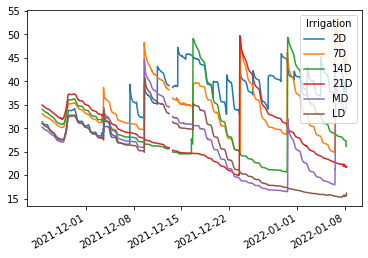

In [8]:
ObsData.loc[:,['D1B','D1I']].groupby('Irrigation',axis=1).mean().multiply(150).plot()

In [9]:
#Rough attempt to fill gaps with synth data failed
# def fillBlanks(v,t):
#     TreatMean = ObsData.loc[v,t[:3]].mean()
#     #yesterday = datetime.datetime.strftime(datetime.datetime.strptime(v,r'%Y-%m-%d %H:%M:%S') - datetime.timedelta(1),r'%Y-%m-%d %H:%M:%S')
#     yesterday = datetime.datetime.strftime(v - datetime.timedelta(1),r'%Y-%m-%d %H:%M:%S')
#     TreatMeanyesterday = ObsData.loc[yesterday:v,t[:3]].mean(axis=1)
#     treatvalsYesterday = ObsData.loc[yesterday:v,t]
#     offset = treatvalsYesterday/TreatMeanyesterday
#     synthVal = TreatMean * offset.mean()
#     return synthVal

# for t in ObsData.columns:
#     if ObsData.loc[:,t].isnull().any():
#         for v in ObsData.index:
#             if np.isnan(ObsData.loc[v,t]):
#                 ObsData.loc[v,t] = fillBlanks(v,t)

In [10]:
datetime.datetime.strptime('2021-12-12 02:00:00',r'%Y-%m-%d %H:%M:%S')

datetime.datetime(2021, 12, 12, 2, 0)

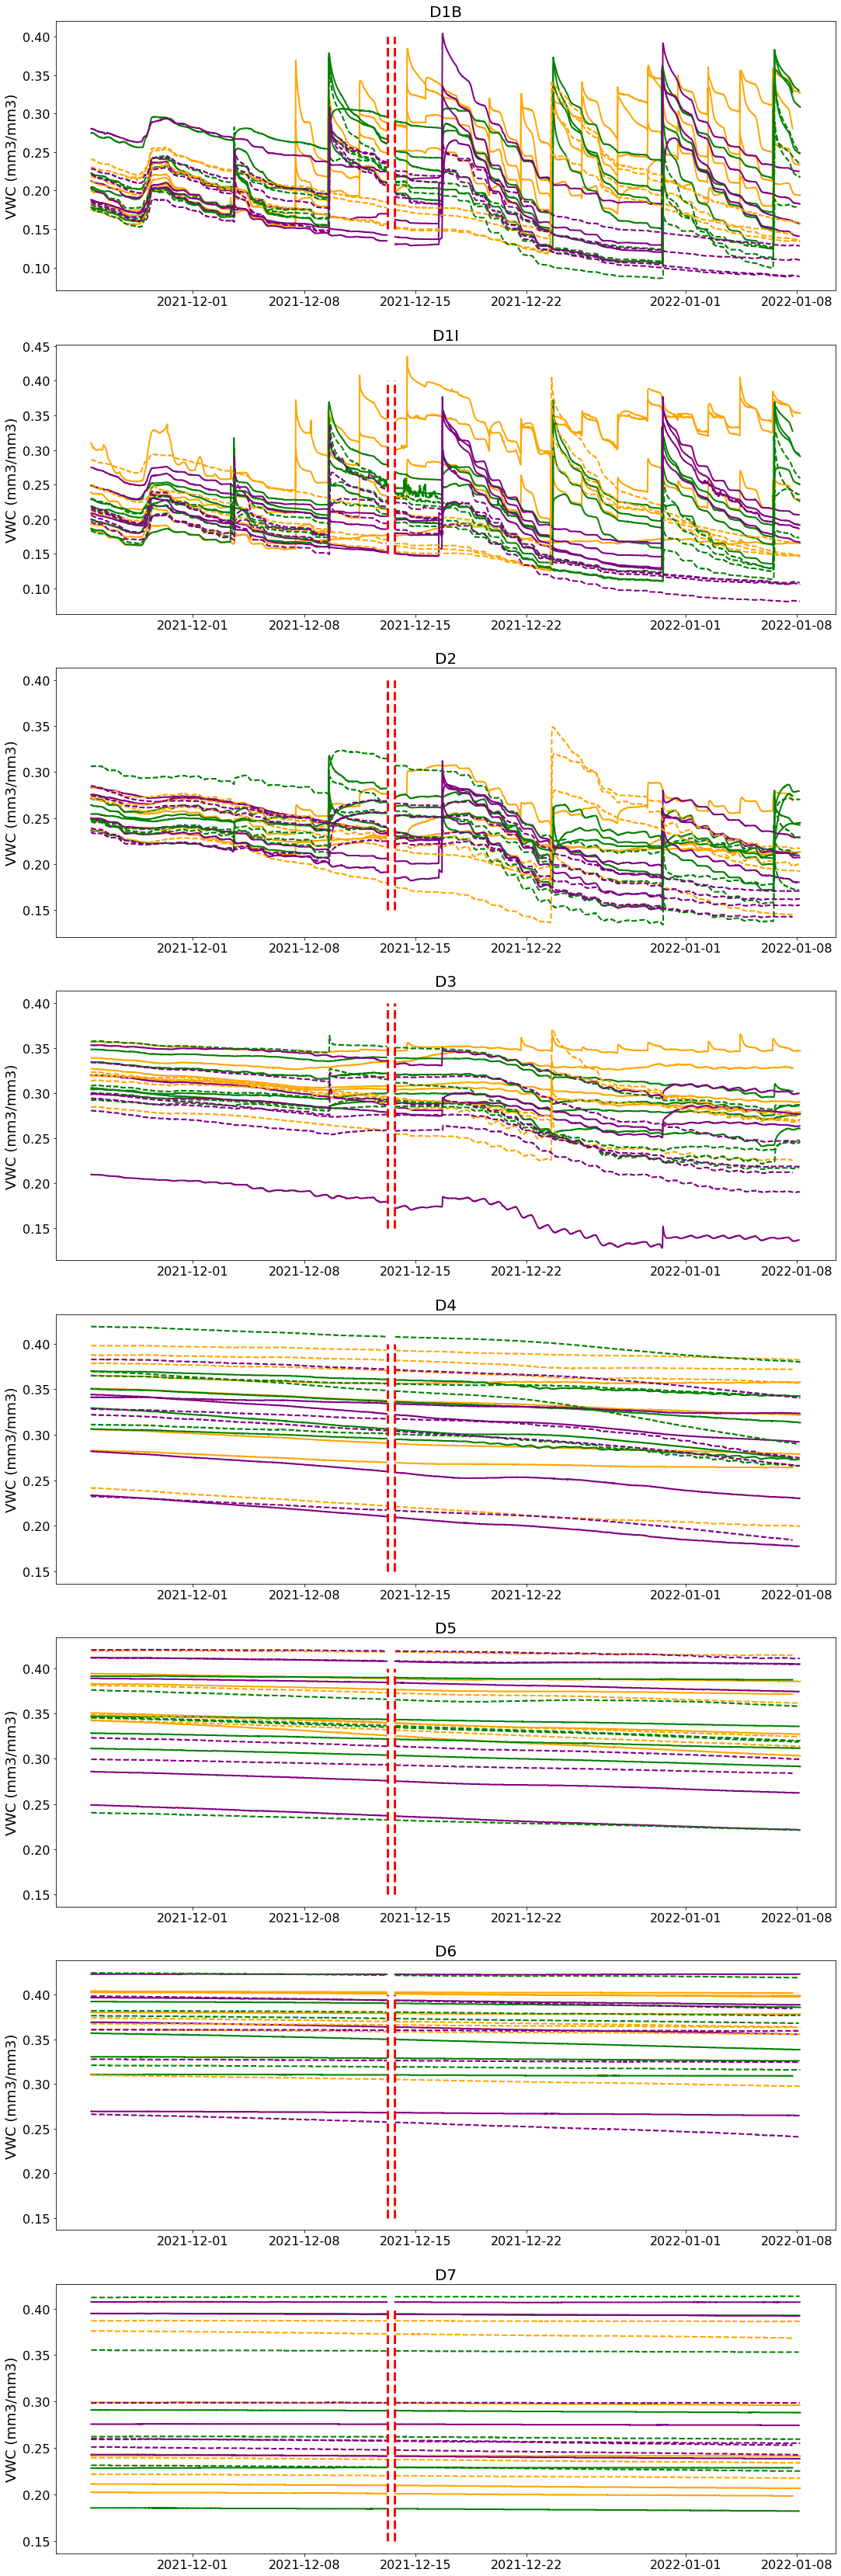

In [11]:
Graph = plt.figure(figsize=(18,60))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(8,1,pos)
    GH.AddIndexedPlot(ObsData.loc[:,D],ax,GPs,2)
    plt.title(D,fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('VWC (mm3/mm3)',fontsize=18)
    plt.plot([datetime.datetime.strptime('2021-12-13 06:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
    plt.plot([datetime.datetime.strptime('2021-12-13 16:00:00',r'%Y-%m-%d %H:%M:%S')]*2,[0.15,.40],'--',color='red',lw=3)
              
    pos +=1

## Calculate soil water deficit

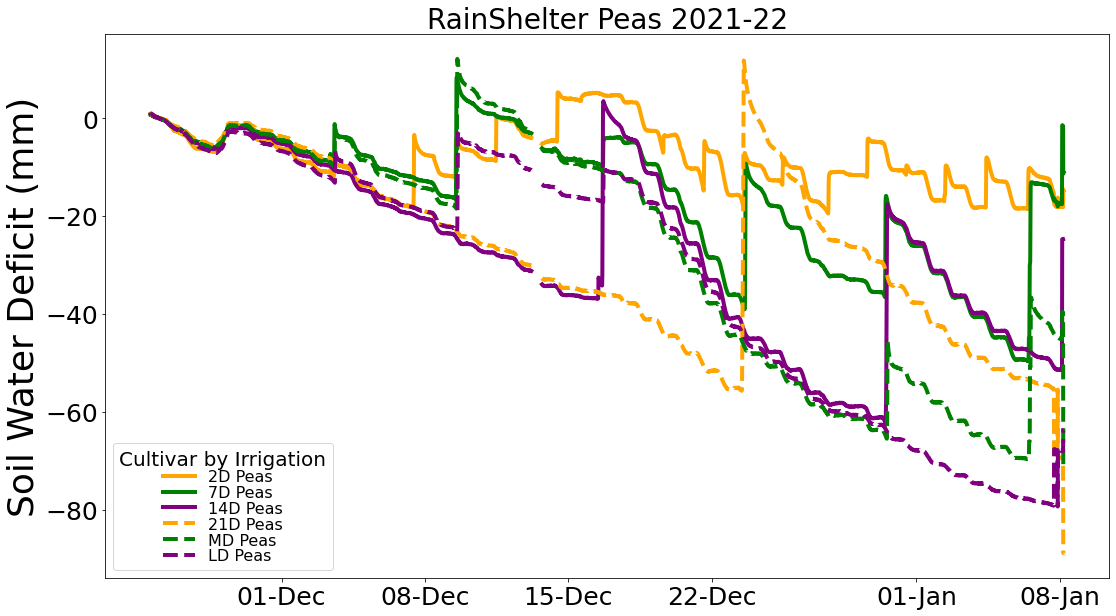

In [12]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  ObsData.groupby(level=['Depth','Irrigation', 'Species'],axis=1).mean()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
               DataMeans.loc[:,'D1B'] * 150/2 + \
               DataMeans.loc[:,'D2'] * 150 + \
               DataMeans.loc[:,'D3'] * 300 + \
               DataMeans.loc[:,'D4'] * 300 + \
               DataMeans.loc[:,'D5'] * 300 + \
               DataMeans.loc[:,'D6'] * 300 + \
               DataMeans.loc[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2021-11-25']   # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater.loc['2021-11-18':,:])    # This calculation only works because field capacity is a multi index series
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Peas 2021-22', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

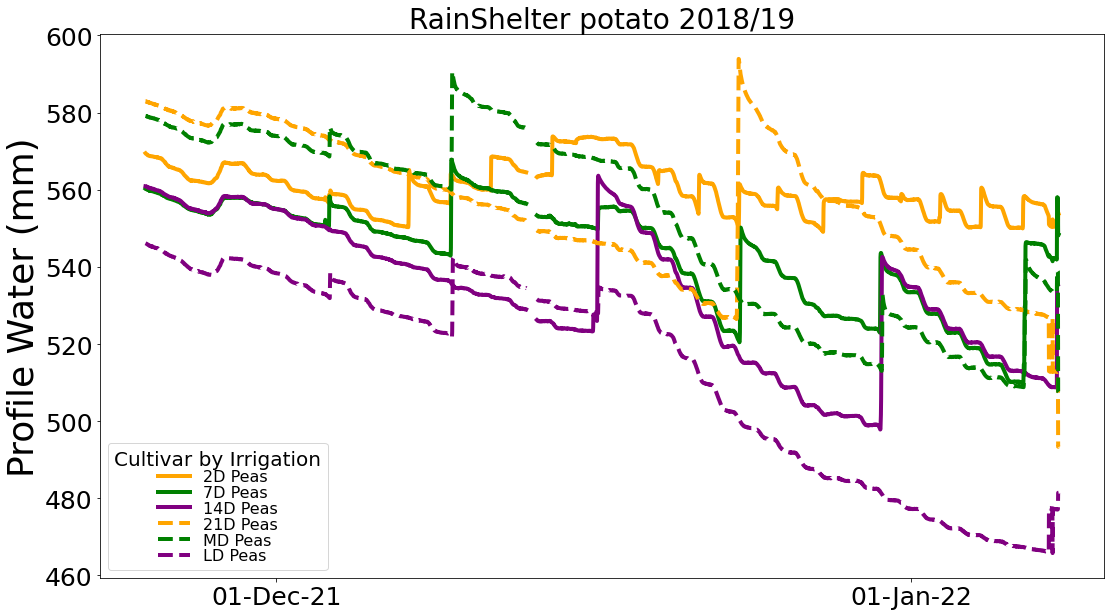

In [13]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(ProfileWater,ax,GPs,4)
plt.ylabel('Profile Water (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter potato 2018/19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

In [14]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Cultivar','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2018-11-03'] 
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2.loc[:'2019-03-21',:])

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(SoilWaterDeficit2,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potatos 2018-19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

AssertionError: Level Cultivar not in index

In [ ]:
FinalSWD = SoilWaterDeficit2.loc['2019-03-21',:].mean(axis=0)

In [ ]:
FinalSWD.to_excel('FinalSWD.xls')

In [ ]:
DeltaWater = ProfileWater2.diff()
DeltaWater.to_pickle('.\DataFrames\ProfileWaterDelta.pkl')
SWD = SoilWaterDeficit.resample('D').mean()
SWD.to_pickle('.\DataFrames\DailySWD.pkl')

In [ ]:
DailyDeltaWater = DeltaWater.resample('d').sum().resample('d').sum()
DailyDeltaWater.where(DailyDeltaWater<2,np.nan,inplace=True)
DailyDeltaWater.to_pickle('.\DataFrames\DailyWU.pkl')